# Melody generation using LSTM  
#### *DEBRAY Clarisse - clarisse.debray@student-cs.fr*
## Imports

In [38]:
import numpy as np
import joblib
import tensorflow as tf
from music21 import stream, note
from tensorflow.keras.utils import to_categorical
import pandas as pd
import random
from music21 import converter, note, stream, chord
import warnings
import itertools
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [39]:
#import de la table
path = 'data\maestro-v3.0.0.csv'
df = pd.read_csv(path)

# Rechargement du modèle Keras depuis le fichier .pkl
model = joblib.load('modele_generation_melodie_midi.pkl')
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

## Définition paramètres

In [40]:
# Paramètres
sequence_length = 50
num_classes = 128

In [41]:
def extraction_notes(file):
    '''
    Fonction pour extraires les notes d'un fichiers midi dans une liste
    avec les éléments int compris entre 0 et 127 
    Pour les accords on ne prend que la note la plus haute (la plus aigue)
    '''
    midi = converter.parse(file)
    L_notes = []
    for e in midi.recurse().notes:
        if e.isNote:
            N = e.pitch.midi
            L_notes.append(N)
        elif e.isChord:
            accords = [n.midi for n in e.pitches]
            N = max(accords)
            L_notes.append(N)
    if len(L_notes)<50:
        return 'null'
    else:
        return L_notes 
    
def ex_notes_tab(df,col_out):
    '''
    Création de la colonne contenant la liste des notes
    '''
    df['midi_file_data'] = 'data/'+df['midi_filename']
    df[col_out] = df['midi_file_data'].apply(extraction_notes)
    return df[df[col_out]!='null']

def sequence_list(L):
    ''' création des séquences de 50 notes et output cette liste et de la note suivante (cible)'''
    sequence_length = 50

    input_sequences = []
    output_notes = []

    for i in range(len(L) - sequence_length):
        seq_in = L[i:i + sequence_length]  
        seq_out = L[i + sequence_length]  
        input_sequences.append(seq_in)
        output_notes.append(seq_out)

    return input_sequences,output_notes

def sequence(dff):
    ''' 
    Application du séquencage à toutes les musiques
    '''
    X,y = [],[]
    for k in dff['notes'].to_list():
        xtemp,ytemp = sequence_list(k)
        X.append(xtemp)
        y.append(ytemp)
    X=list(itertools.chain(*X))
    y=list(itertools.chain(*y))

    return pd.DataFrame({"X":X,"y":y})

def colonnes(df):
    ''' mise en forme : 1 temps = 1 colonne = 1 note '''
    df_expanded = df['X'].apply(pd.Series)
    df_expanded['y'] = df['y']
    return df_expanded

### Seed

In [42]:
music_seed = random.randint(0,df.shape[0]-1) #Choix aléatoire de la seed
dfseed = colonnes(sequence(ex_notes_tab(df.iloc[music_seed:music_seed+1],'notes')))
ligne_seed = random.randint(0,dfseed.shape[0]-1)
seed_sequence = dfseed.iloc[ligne_seed, :50].astype(int).tolist()

## Génération

In [43]:
def generate_sequence(model, seed_sequence, length=100, noise_std=2.0, num_classes=128):
    '''Génère une séquence de notes à partir d'une seed'''
    generated = list(seed_sequence)

    for _ in range(length):
        input_seq_raw = generated[-50:]
        input_seq = to_categorical(input_seq_raw, num_classes=num_classes).reshape(1, 50, num_classes)
        pred_distribution = model.predict(input_seq, verbose=0)[0]

        if noise_std > 0.0:
            pred_distribution += np.random.normal(0, noise_std, size=pred_distribution.shape)
            pred_distribution = np.clip(pred_distribution, 0, None)

        next_val = int(np.argmax(pred_distribution))
        generated.append(next_val)

    return generated

def applatissement(generated):
    '''Ramène les notes dans une plage plus raisonnable pour l'oreille'''
    generated2 = []
    for k, n in enumerate(generated):
        if k == 0:
            generated2.append(n)
        else:
            while n < 48:
                n += 12
            while n > 80:
                n -= 12
            generated2.append(n)
    return generated2

# Génération et affichage
generated = generate_sequence(model, seed_sequence, length=100, noise_std=2.0)
generated2 = applatissement(generated)


## Résultats

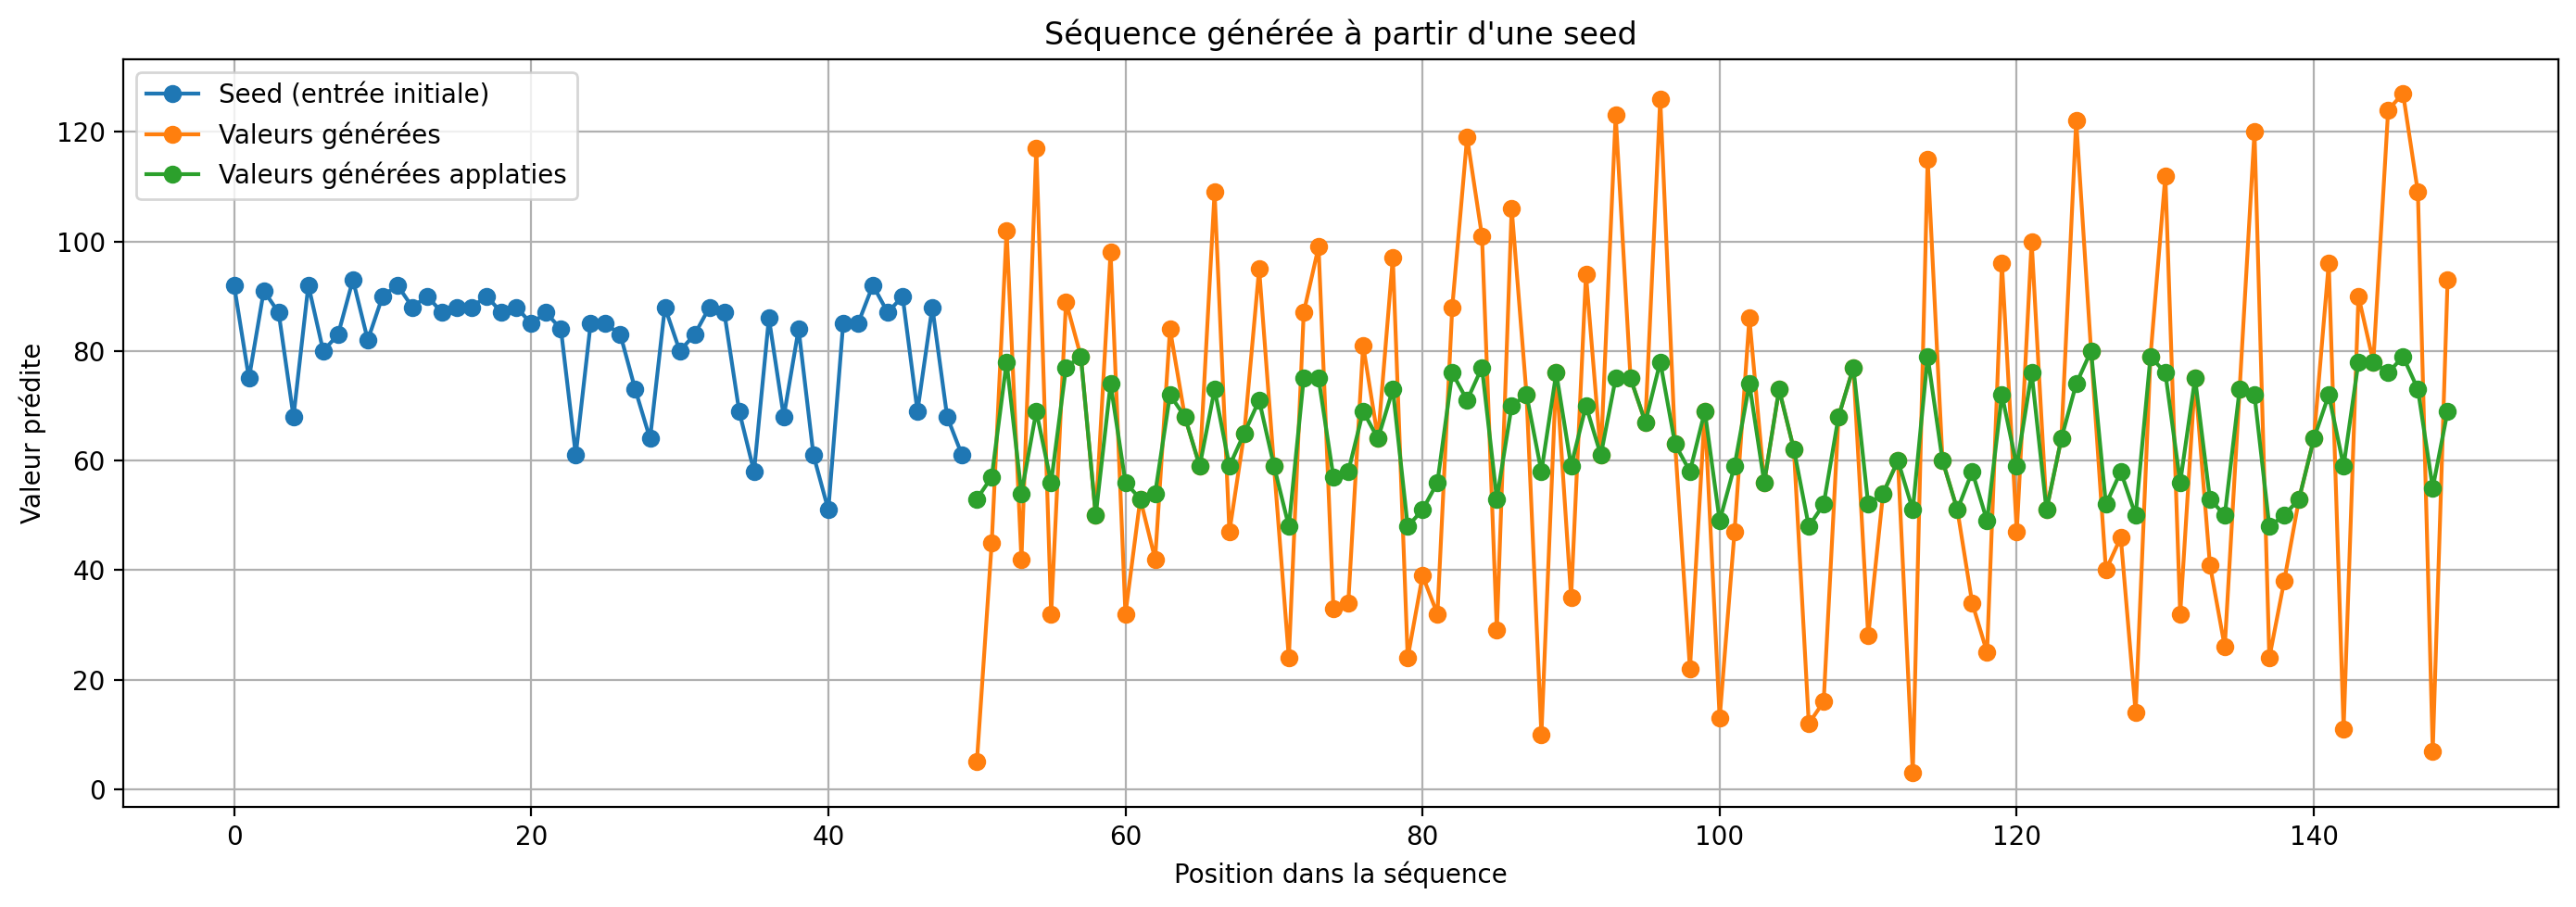

In [44]:
#Visualisation de la génération
plt.figure(figsize=(14, 5))
plt.plot(range(len(seed_sequence)), seed_sequence, label='Seed (entrée initiale)', marker='o')
plt.plot(range(len(seed_sequence), len(generated)), generated[len(seed_sequence):], label='Valeurs générées', marker='o')
plt.plot(range(len(seed_sequence), len(generated2)), generated2[len(seed_sequence):], label='Valeurs générées applaties', marker='o')
plt.title("Séquence générée à partir d'une seed")
plt.xlabel("Position dans la séquence")
plt.ylabel("Valeur prédite")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# Création du flux MIDI pour écouter
s = stream.Stream()
for e in generated2:
    n = note.Note(e)
    n.quarterLength = 0.5
    s.append(n)

s.show('midi')